In [2]:
# define relevants paths and load functions and libraries

%run Z:\\home\\shared\\Gaia\\Coliseum\\Delays\\paper_code\\Analysis\\helper_functions\\functions_analysis.py
    
data_path = 'paper_code\\Datasets\\' # your data path
saving_path = 'paper_code\\Figures_output\\' # your saving figures path

In [3]:
# import relevant datasets

# load the main dataset
file= ''.join([data_path,'neurons_datasets\\delayBA_tuning_dataset.mat'])
data_dict = mat73.loadmat(file)
DAT=data_dict['delayBA_dataset']

# check keys available
print(DAT.keys())

# extract all keys
for k in DAT.keys():
    globals()[k] = DAT[k]

dict_keys(['all_boot_aud', 'all_boot_vis', 'animal_ID', 'coord3D', 'experiment_ID', 'modality', 'peaks', 'resp', 'responsive', 'spikes', 'spikes5ms', 'stimuli'])


In [7]:
# To plot example neurons you need to load the IFR and the raster
plot_examples = 1

if plot_examples == 1:
    # load the raster data
    file=''.join([data_path,'neurons_datasets\\raster_delayBA_tuning_dataset.mat'])
    data_dict = mat73.loadmat(file)
    raster=data_dict['raster']
    raster = raster['tr']

    # load the IFR data
    file=''.join([data_path,'neurons_datasets\\psth_delayBA_tuning_dataset.mat'])
    data_dict = mat73.loadmat(file)
    IFRs = data_dict['neuron_IFR']['mean']

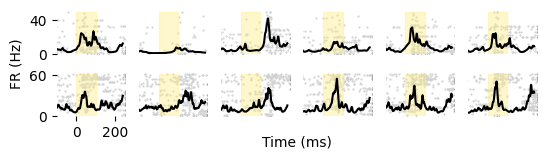

In [8]:
# Plot 2 examples neurons responding to all set of AV stimuli - Fig 3A

delay_cond = np.array([7,8,0,2,4,6]) # so I first plot the unisensory
ids = np.array([502,499]) #here select the neurons

# Plot them
dims = (2, delay_cond.shape[0])
fig, axs = plt.subplots(*dims, figsize=(6, 1.33),gridspec_kw={'wspace': 0.2})#,layout="constrained")#,

plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
n_stim=delay_cond.shape[0]

pos = np.arange(len(ids)*n_stim)
pos = pos.reshape(n_stim,-1)
stims = delay_cond 

# determine the position of the psth
this_order = np.arange(0,n_stim*2).reshape(2,n_stim)

for i in range(len(ids)):

    actual = IFRs[ids[i]] # now this is shaped trials x time
    actual = np.reshape(actual,(-1,1000))  # Now this is shaped trials x time
    maxFR = np.nanmax(actual)
    raster_now = raster[ids[i]]

    for t in range(n_stim):
        this_ax = axs[i, t]
        x = raster_now['x'][stims[t]][1::3]
        y = raster_now['y'][stims[t]][1::3]
        this_ax.grid(False)
        this_ax.set_xlim([-0.1, 0.25])#[-0.3, 0.5] # here I set the time 
        this_ax.set_ylim([0, 53])
        
        start = 0 
        hight = 50
        this_ax.scatter(x, y, s=0.3, c='#A0A0A0')
        this_color = 'gold'
        rect = Rectangle((start, 0), 0.1, hight, linewidth=1, edgecolor=this_color, facecolor=this_color, zorder=1,alpha=0.4)
        this_ax.add_patch(rect)
        this_ax.set_xticks([])
        this_ax.set_yticks([]) 
        # Remove the spines from the original subplot
        this_ax.spines[:].set_visible(False)
        
        # Ticks only for the first plot
        if t == 0 and i == len(ids)-1:
            this_ax.set_xticks([0, 0.2])
            this_ax.set_xticklabels(['0','200'],fontsize = 10)
        
        # Plot over the current plot
        this_ax2 = fig.add_subplot(2,n_stim,this_order[i,t]+1)
        this_ax2.patch.set_alpha(0.5)
        # Remove the spines from the twinned axes
        this_ax2.spines[:].set_visible(False)
        
        this_ax2.plot(actual[stims[t], :], c='black')
        this_ax2.set_xlim([299, 1000]) #this goes from -1 to 1s
        this_ax2.set_ylim([0, maxFR + 10])
        
        this_ax2.set_xticks([])
        this_ax2.set_yticks([])
        
        if t==0:
            this_ax2.set_yticks([0,np.round(maxFR,-1)])  
            this_ax2.set_yticklabels([0,int(np.round(maxFR,-1))],fontsize = 10)

this_ax3 = fig.add_subplot(111)
this_ax3.patch.set_alpha(0)
this_ax3.spines[:].set_visible(False)
this_ax3.set_yticks([])
this_ax3.set_xticks([])
this_ax3.set_ylabel('FR (Hz)',labelpad=20,fontsize = 10)
this_ax3.set_xlabel('Time (ms)', labelpad=10,fontsize = 10)

fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# define a saving directory and save it 
dir = ''.join([saving_path,'Supplementary_Figure3A.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)  

In [4]:
# Plot quantification of median MII for each AV delay presented - Fig 3B

# first calculate the MII
spikes_smooth = spikes

# get spikes and labels in the right shape 
all_spikes_sub_mean, all_labels = shift_sum_BA(spikes_smooth,sub_mean=1,factor = 1)

# reshape it in a two dimensional array 
all_spikes_reshaped = all_spikes_sub_mean.reshape(all_spikes_sub_mean.shape[0],-1)
all_spikes_reshaped = all_spikes_reshaped.reshape(all_spikes_sub_mean.shape[0], -1, 50, all_spikes_sub_mean.shape[2])

# Compute the mean along the second axis
mean_array = np.mean(all_spikes_reshaped, axis=2)

spikes_smooth = mean_array

n_neurons = spikes_smooth.shape[0]
binSize = 0.001

# find the peaks of the response
peaks_all = np.zeros((n_neurons,spikes_smooth.shape[1])) # N x T

for n in range(n_neurons): # random order of trial for each neuron 
    
    this_neuron_spikes = spikes_smooth[n,:,:]    
    
    # find the peakFR
    max_pos = np.argmax(this_neuron_spikes,axis=1) 
    
    for r in range(this_neuron_spikes.shape[0]):
        peaks_all[n,r] = np.nanmean(this_neuron_spikes[r,max_pos[r]-1:max_pos[r]+2])/binSize
        #peaks_all[n,r] = np.nanmean(this_neuron_spikes[r,max_pos[r]-5:max_pos[r]+5])/binSize
        #peaks_all[n,r] = np.nanmean(this_neuron_spikes[r,max_pos[r]-1:max_pos[r]+1])/binSize
        #peaks_all[n,r] = this_neuron_spikes[r,max_pos[r]]/binSize
        

10
5
3
its correct
(1104, 16, 50, 25)
(1104, 16, 25)


C:\Users\bianchg\AppData\Local\Temp\2\ipykernel_12984\3729967369.py:37: RuntimeWarning: Mean of empty slice
  peaks_all[n,r] = np.nanmean(this_neuron_spikes[r,max_pos[r]-1:max_pos[r]+2])/binSize


In [5]:
# now get the MII
n_delays = 7
n_uni = 2
MII_all = np.zeros((peaks_all.shape[0],peaks.shape[1]-2))
MII_all_old = np.zeros((peaks_all.shape[0],peaks.shape[1]-2))
for n in range(peaks_all.shape[0]):
    for d in range(n_delays):
        del_FR = peaks_all[n,d]
        sum_FR = peaks_all[n,n_delays+n_uni+d]
        sum_FR_old = peaks_all[n,n_delays]+peaks_all[n,n_delays+1]

        if sum_FR <= 0 or del_FR <= 0:
            MII_all[n,d] = np.nan
            MII_all_old[n,d] = np.nan
        else:
            MII_all[n,d] = (del_FR - sum_FR)/sum_FR#(del_FR + sum_FR)
            MII_all_old[n,d] = (del_FR - sum_FR_old)/(del_FR + sum_FR_old)

# Convert infinite values to NaN
MII_all[np.isinf(MII_all)] = np.nan

In [7]:
# Then let's plot the distribution of the preferred delay

sig_del = []
which_tr = []
for i in range(peaks.shape[0]):
    if responsive[i]>0:
        y = peaks[i,:-2]

        vis_FR = peaks[i,-2]
        aud_FR = peaks[i,-1]

        if vis_FR>aud_FR:
            boot_out = all_boot_vis[i,:]
        elif aud_FR>vis_FR:
            boot_out = all_boot_aud[i,:]

        pos_sig = np.argwhere(boot_out>0)

        if len(pos_sig)>0:
            sig_del.append(i)
            tr = pos_sig[np.argmax(y[pos_sig])]
            #tr = np.argmax(y)  # Make sure 'y' is defined and 'np' (NumPy) is imported
            which_tr.append(tr)

sig_del = np.array(sig_del)
pref_delay=np.array(which_tr)[:,0]

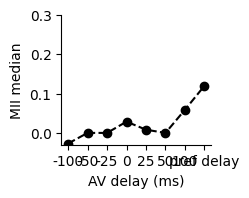

In [8]:
# plot the differences in median between distributions
dims = (1, 1)
fig, this_ax = plt.subplots(*dims, figsize=(1.5, 1.3))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

pop_median=[]
n_delays = 7
for i in range(n_delays): #iterate through delays
    
    curr_peaks = MII_all[sig_del,i]    
    # Remove NaN values
    data_without_nans =curr_peaks[~np.isnan(curr_peaks)]

    # Compute the median
    pop_median.append(np.nanmedian(data_without_nans))

# append the median of the pref delay
pop_median.append(np.nanmedian(MII_all[sig_del,pref_delay]))
# plot the median 
this_ax.plot(pop_median,'o--k')
this_ax.set_xlabel('AV delay (ms)')
this_ax.set_ylabel('MII median')
this_ax.set_ylim([-0.03, 0.3])
arr_str =['-100','-50','-25','0','25','50','100','pref delay']
this_ax.set_xticks(np.arange(0, 8), arr_str,fontsize=10)
this_ax.spines["right"].set_visible(False)
this_ax.spines['top'].set_visible(False)
this_ax.set_aspect('auto')

# define a saving directory and save it 
dir = ''.join([saving_path,'Supplementary_Figure3B.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)  

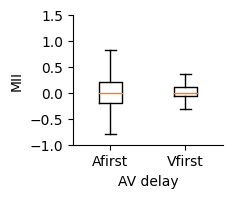

In [9]:
# Plot distribution MII sound before and after - Fig 3C

filtered_data_AF = MII_all[sig_del, :3]
filtered_data_AF_non_nan = filtered_data_AF[~np.isnan(filtered_data_AF)]

filtered_data_VF = MII_all[sig_del, 5:]
filtered_data_VF_non_nan = filtered_data_VF[~np.isnan(filtered_data_VF)]

dims = (1, 1)
fig, this_ax = plt.subplots(*dims, figsize=(1.5, 1.3))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1) 
x = [filtered_data_AF_non_nan,filtered_data_VF_non_nan]

this_ax.boxplot(x,showfliers=False,widths=0.3)
this_ax.spines["right"].set_visible(False)
this_ax.spines['top'].set_visible(False)
this_ax.set_xlabel('AV delay')
this_ax.set_xticklabels(['Afirst','Vfirst'])
this_ax.set_ylabel('MII')
this_ax.set_ylim([-1,1.5])
this_ax.set_yticks([-1,-0.5,0,0.5,1,1.5])

# define a saving directory and save it 
dir = ''.join([saving_path,'Supplementary_Figure3C.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0) 